# About the Problem

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. This problem deals  with combining historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

# Data Reading

In [ ]:
import pandas as pd
import numpy as np

In [7]:
data = pd.read_csv("Daily Bike Sharing.csv", index_col="dteday", parse_dates=True)
data.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
#selecting relevant variables
dataset = data.loc[:, ["cnt", "holiday", "workingday", "weathersit", 
                       "temp", "atemp", "hum", "windspeed"]]

In [148]:
dataset.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900


# Data Transformation

In [9]:
#renaming dependent variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset.head()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [10]:
#setting frequency of dataset
data = data.asfreq("D")

In [23]:
#checking for null values
dataset.isna().sum()

y             0
holiday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

# Visualization

<Axes: xlabel='dteday'>

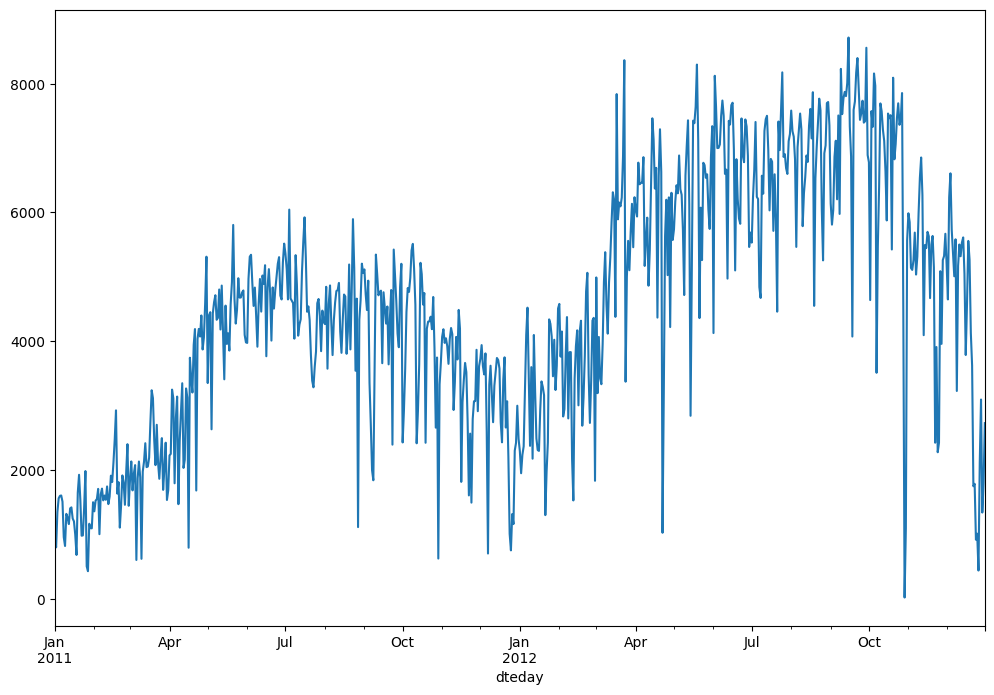

In [13]:
import matplotlib.pyplot as plt
dataset["y"].plot(figsize = (12,8))

# Checking for Stationarity

In [26]:
# Augmented Dickey Fuller test
from statsmodels.tsa.stattools import adfuller
adfuller(dataset['y'])

(-1.8774481444374314,
 0.3427434403392186,
 13,
 717,
 {'1%': -3.439503230053971,
  '5%': -2.8655794463678346,
  '10%': -2.5689210707289982},
 11740.390931163352)

The p-value is greater than 0.05 which indicates that the data is non stationary. Hence, we should use ARIMA models over ARMA

In [30]:
# checking stationarity for first order difference
y_diff = pd.DataFrame(dataset['y'] - dataset['y'].shift(1))
y_diff.head()

,y
dteday,
2011-01-01,NaN
2011-01-02,-184.0
2011-01-03,548.0
2011-01-04,213.0
2011-01-05,38.0


In [33]:
#removing missing value
y_diff = y_diff.dropna()
y_diff.head()

,y
dteday,
2011-01-02,-184.0
2011-01-03,548.0
2011-01-04,213.0
2011-01-05,38.0
2011-01-06,6.0


In [35]:
# Augmented Dickey Fuller test for y_diff
from statsmodels.tsa.stattools import adfuller
adfuller(y_diff)

(-11.778809074151923,
 1.0467797548017554e-21,
 12,
 717,
 {'1%': -3.439503230053971,
  '5%': -2.8655794463678346,
  '10%': -2.5689210707289982},
 11726.343733056146)

The p-value is less than 0.05 which indicates that the data is stationary. Hence, integration order for ARIMA looks like 1

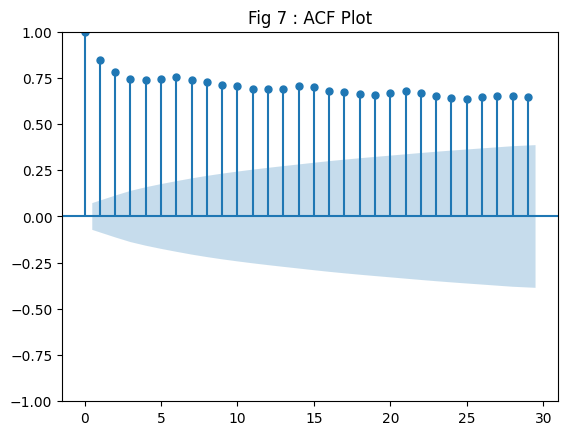

In [28]:
#plotting acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dataset['y'])
plt.title('Fig 7 : ACF Plot')
plt.show()

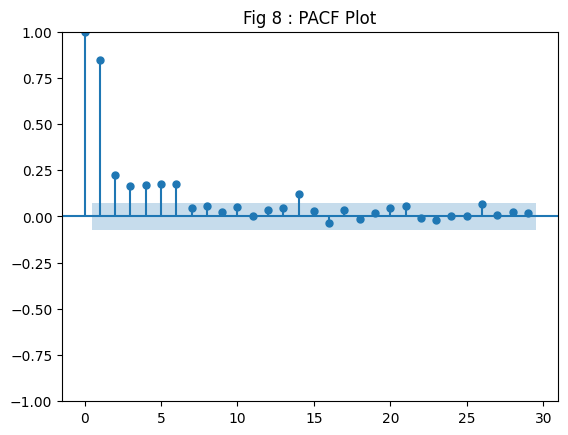

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dataset['y'])
plt.title('Fig 8 : PACF Plot')
plt.show()

The PACF plot indicates an AR order of 6, since there are 6 lags having significant correlation values

In [37]:
dataset.head()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


# Seasonal decomposition

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

The line chart showed inconsistent variance which shows multiplicative seasonality.

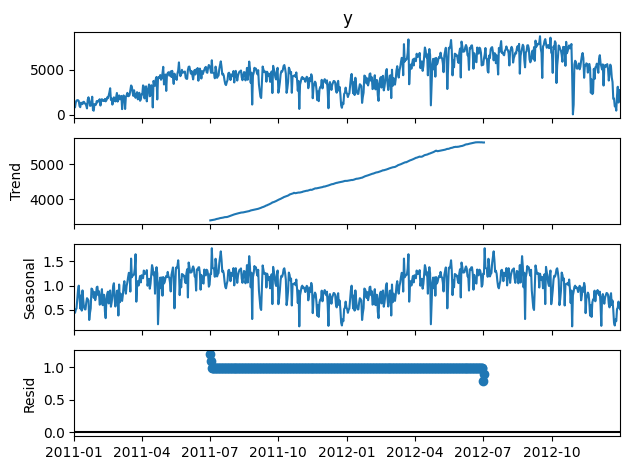

In [85]:
decomposition = seasonal_decompose(x = dataset.y, model = 'multiplicative', period = 365)
decomposition.plot()
plt.show()

This shows an upward trend and the seasonality component being high for the middle of the year

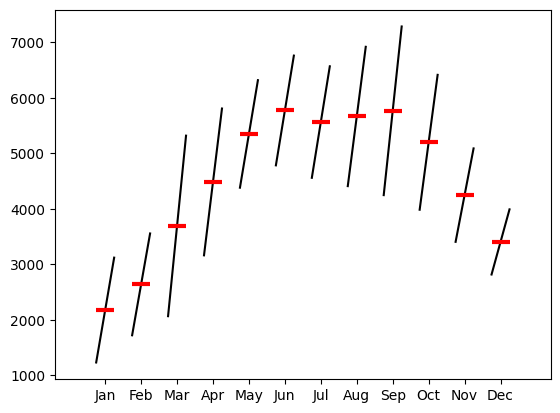

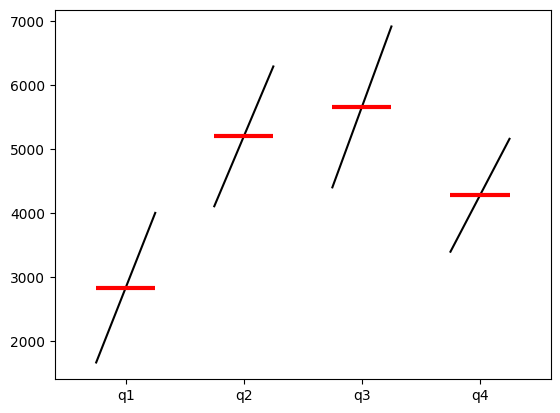

In [86]:
#seasonality charts
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
month_plot(dataset.y.resample(rule = 'MS').mean())
quarter_plot(dataset.y.resample(rule = 'Q').mean())
plt.show()

# Splitting the data into Train and Test

In [80]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-12-31,2729,0,1,2,0.215833,0.223487,0.5775,0.154846


In [81]:
#exogenous variables
train_exog = training_set.iloc[:,1:]
test_exog = test_set.iloc[:,1:]
test_exog.head()

,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,
2012-12-01,0,0,2,0.298333,0.316904,0.806667,0.059704
2012-12-02,0,0,2,0.347500,0.359208,0.823333,0.124379
2012-12-03,0,1,1,0.452500,0.455796,0.767500,0.082721
2012-12-04,0,1,1,0.475833,0.469054,0.733750,0.174129
2012-12-05,0,1,1,0.438333,0.428012,0.485000,0.324021


# SARIMAX

In [82]:
from pmdarima import auto_arima

In [83]:
#forecasting model
model = auto_arima(y = training_set['y'],
                   X = train_exog,
                   m = 7,
                   seasonal = True,
                   stepwise = False)

In [87]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -5596.921
Date:                Fri, 21 Jul 2023   AIC                          11217.842
Time:                        01:56:16   BIC                          11272.438
Sample:                    01-01-2011   HQIC                         11238.948
                         - 11-30-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.3382      5.562      0.780      0.435      -6.564      15.240
holiday     -240.2467    129.104     -1.861      0.063    -493.287      12.793
workingday    89.1818     60.521      1.474      0.141     -29.437     207.801
weathersit  -460.2136     51.302     -8.971      0.000    -560.763    -359.664
temp        3421.6044   1170.505      2.923      0.003    1127.456    5715.753
atemp       1970.5737   1197.091      1.646      0.100    -375.682    4316.829
hum        -2280.4153    198.511    -11.488      0.000   -2669.490   -1891.341
windspeed  -2275.5693    373.364     -6.095      0.000   -3007.349   -1543.790
ma.L1         -0.5546      0.028    -19.644      0.000      -0.610      -0.499
ma.L2         -0.1348      0.039     -3.422      0.001      -0.212      -0.058
ma.L3         -0.1443      0.040     -3.607      0.000      -0.223      -0.066
sigma2      5.262e+05   2.02e+04     26.108      0.000    4.87e+05    5.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               623.72
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
#predictions
predictions_sarimax = pd.Series(model.predict(n_periods= test_days,
                              X = test_exog)).rename("SARIMAX")
predictions_sarimax.index = test_set.index                              
predictions_sarimax

dteday
2012-12-01    4288.803140
2012-12-02    4216.823837
2012-12-03    5448.135106
2012-12-04    5427.393769
2012-12-05    5448.709171
2012-12-06    4779.492903
2012-12-07    4189.672334
2012-12-08    4177.174949
2012-12-09    4075.837907
2012-12-10    4317.426320
2012-12-11    4356.060656
2012-12-12    4524.421626
2012-12-13    5071.315953
2012-12-14    4766.596730
2012-12-15    4953.763705
2012-12-16    4274.513996
2012-12-17    4385.551746
2012-12-18    5195.128795
2012-12-19    4976.360302
2012-12-20    4518.812911
2012-12-21    4149.021673
2012-12-22    4375.054879
2012-12-23    4811.962525
2012-12-24    3892.390686
2012-12-25    3763.366900
2012-12-26    2788.394115
2012-12-27    3614.637652
2012-12-28    4258.538142
2012-12-29    3847.999139
2012-12-30    4399.660412
2012-12-31    4110.980596
Name: SARIMAX, dtype: float64

<Axes: xlabel='dteday'>

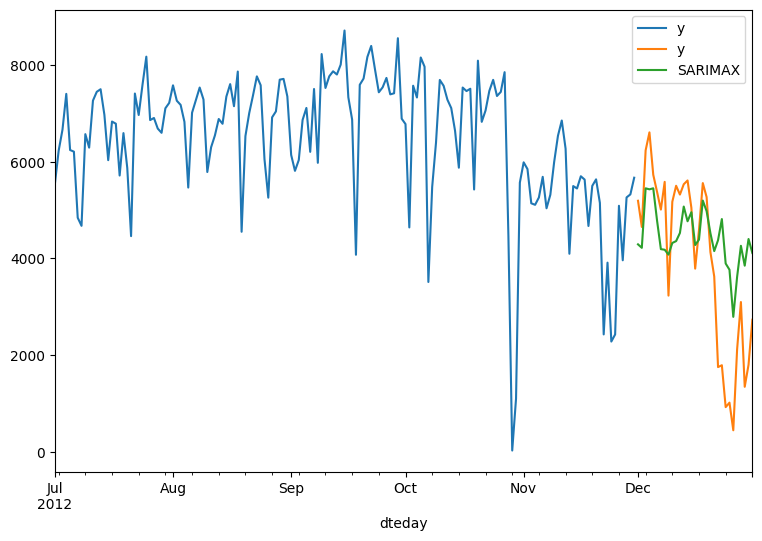

In [89]:
#visualization
training_set['y']['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_sarimax.plot(legend = True)

In [90]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_sarimax),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_sarimax)), 0))

1180.0
1480.0


In [91]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_sarimax)

71.25963116743237

# FB Prophet

In [94]:
#renaming feature names
dataset = dataset.reset_index()
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [95]:
# extracting information about holidays
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({'holiday' : 'holi',
                         'ds': pd.to_datetime(holiday_dates),
                         'lower_window': -3,
                         'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [96]:
#removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


In [110]:
training_set = training_set.reset_index()
training_set = training_set.rename(columns = {'cnt' : 'y'})
training_set = training_set.rename(columns = {'dteday' : 'ds'})
test_set = test_set.reset_index()
test_set = test_set.rename(columns = {'cnt' : 'y'})
test_set = test_set.rename(columns = {'dteday' : 'ds'})

In [112]:
#modeling
from prophet import Prophet
m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

02:20:13 - cmdstanpy - INFO - Chain [1] start processing
02:20:13 - cmdstanpy - INFO - Chain [1] done processing


In [113]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [114]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [115]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1721.860258,22.080390,1862.738295,1721.860258,1721.860258,-0.038856,-0.038856,-0.038856,-0.302283,...,0.000000,0.000000,0.000000,-0.272341,-0.272341,-0.272341,0.0,0.0,0.0,979.959663
1,2011-01-02,1731.402263,-71.127467,1811.126216,1731.402263,1731.402263,-0.042126,-0.042126,-0.042126,-0.307526,...,0.000000,0.000000,0.000000,-0.264594,-0.264594,-0.264594,0.0,0.0,0.0,802.997533
2,2011-01-03,1740.944267,131.428686,1931.558335,1740.944267,1740.944267,-0.096490,-0.096490,-0.096490,-0.079690,...,0.149082,0.149082,0.149082,-0.255562,-0.255562,-0.255562,0.0,0.0,0.0,1050.999326
3,2011-01-04,1750.486272,175.397536,2048.003849,1750.486272,1750.486272,-0.088975,-0.088975,-0.088975,-0.071934,...,0.149082,0.149082,0.149082,-0.245365,-0.245365,-0.245365,0.0,0.0,0.0,1140.815861
4,2011-01-05,1760.028276,358.355195,2121.380060,1760.028276,1760.028276,-0.083302,-0.083302,-0.083302,0.000700,...,0.149082,0.149082,0.149082,-0.234146,-0.234146,-0.234146,0.0,0.0,0.0,1279.789066


In [116]:
#predictions
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

700    4173.602415
701    3509.660639
702    5697.921503
703    5704.213384
704    5397.463439
Name: prophet, dtype: float64

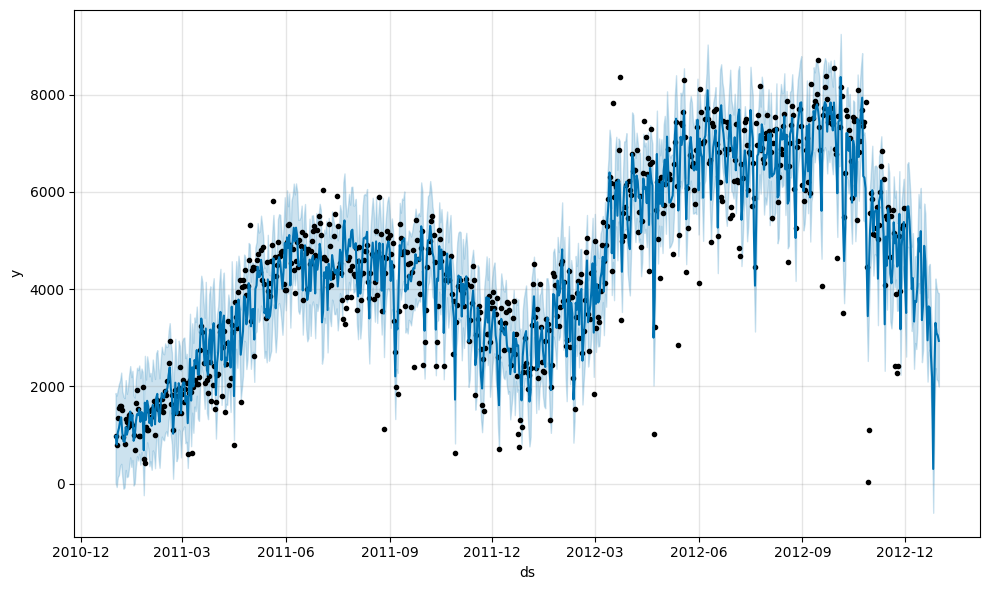

In [117]:
#visualization forecast
m.plot(forecast)

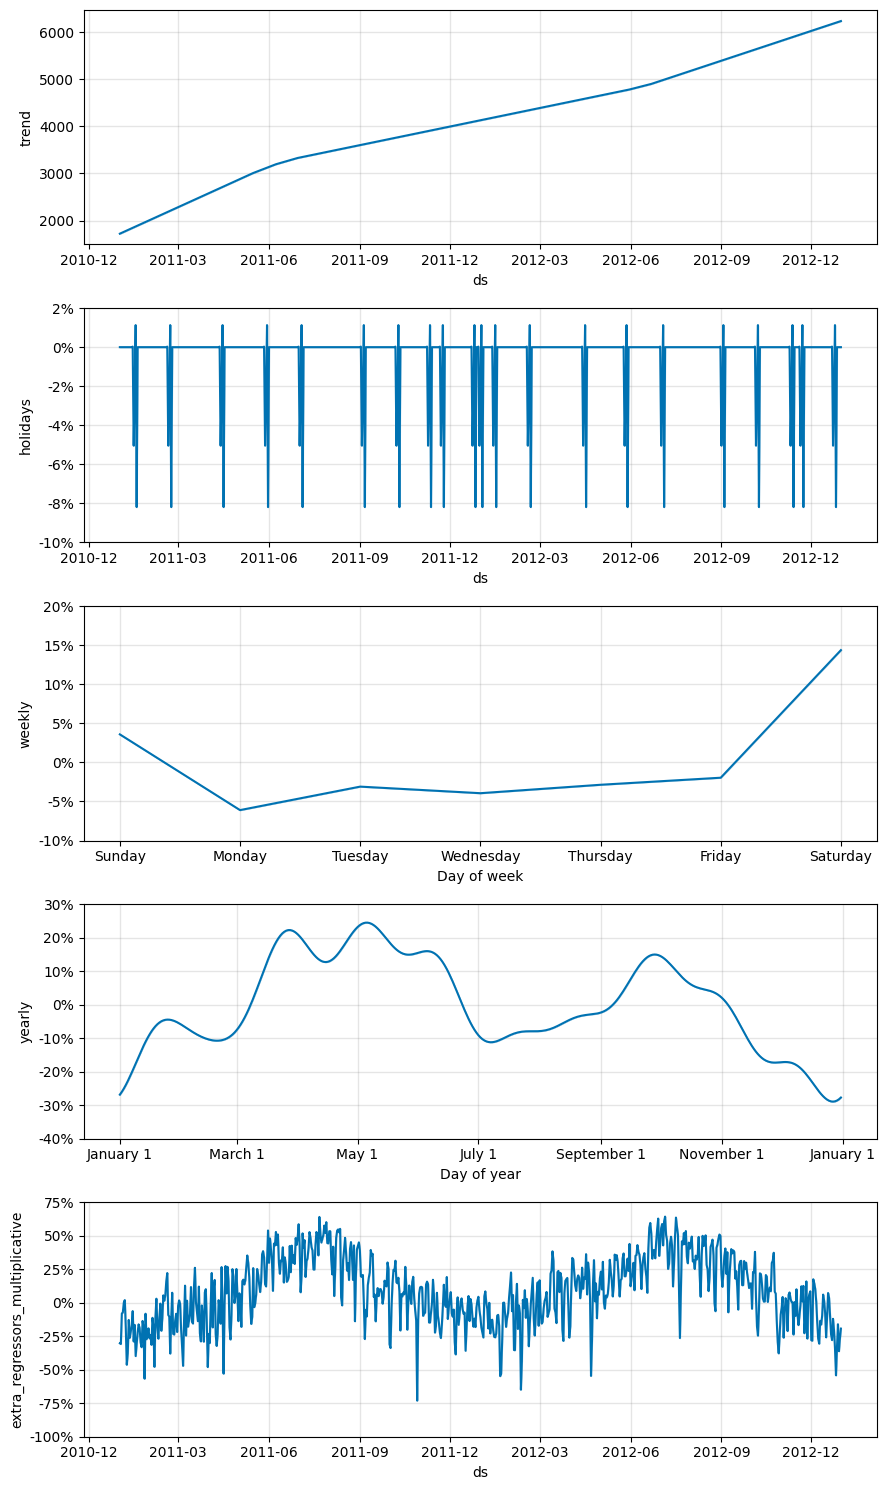

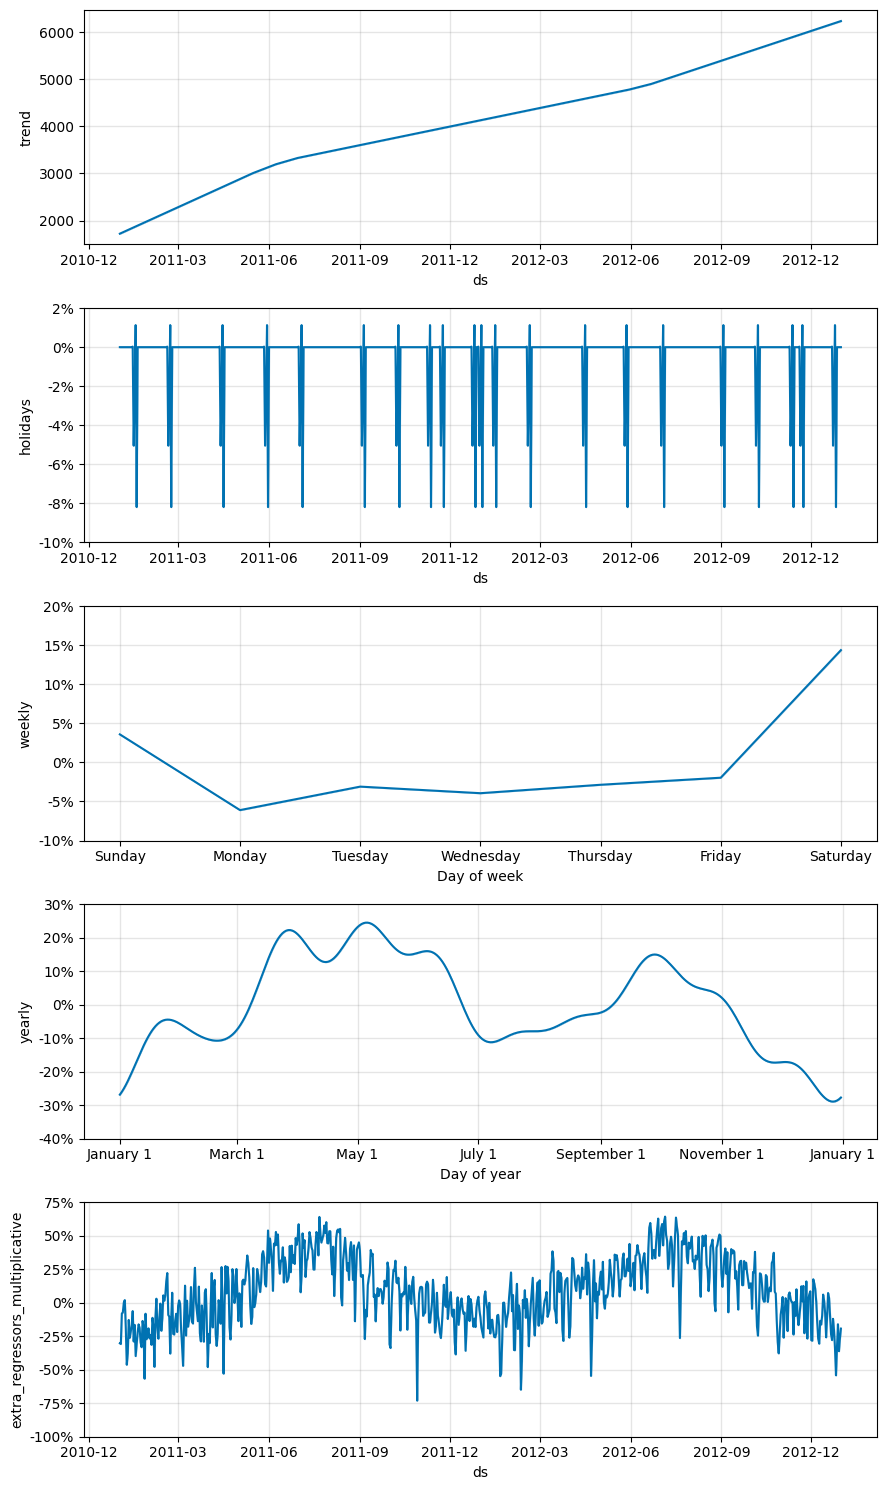

In [118]:
#plot components
m.plot_components(forecast)

In [119]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))

862.0
1030.0


In [120]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

34.965932876915375

## Cross Validation

In [122]:
#CV
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8164.076831,7456.842166,8855.790964,5463,2012-06-28
1,2012-06-30,7242.259039,6433.187218,7970.614106,5687,2012-06-28
2,2012-07-01,7433.982288,6694.230960,8206.354327,5531,2012-06-28
3,2012-07-02,6786.106599,6011.577933,7576.118051,6227,2012-06-28
4,2012-07-03,7444.260174,6653.450759,8268.081946,6660,2012-06-28


In [123]:
#MAE and RMSE
print(round(mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print(round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])), 0))
print(MAPE(df_cv['y'], df_cv['yhat']))

1008.0
1268.0
126.37699525765665


In [124]:
## Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1],
              'holidays_prior_scale': [5, 10, 20]}
grid = ParameterGrid(param_grid)
list(grid)[:3]            

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [125]:
rmse = []
for params in grid:
  #build model
  m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('workingday')
  m.add_regressor('weathersit')
  m.add_regressor('temp')
  m.add_regressor('atemp')
  m.add_regressor('hum')
  m.add_regressor('windspeed')
  m.fit(training_set)

  #cross-validation
  df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
  
  #gather the results
  error = np.sqrt(mean_squared_error(df_cv['y'], 
                                     df_cv['yhat']))
  rmse.append(error)

02:23:22 - cmdstanpy - INFO - Chain [1] start processing
02:23:23 - cmdstanpy - INFO - Chain [1] done processing
02:23:26 - cmdstanpy - INFO - Chain [1] start processing
02:23:26 - cmdstanpy - INFO - Chain [1] done processing
02:23:30 - cmdstanpy - INFO - Chain [1] start processing
02:23:31 - cmdstanpy - INFO - Chain [1] done processing
02:23:34 - cmdstanpy - INFO - Chain [1] start processing
02:23:35 - cmdstanpy - INFO - Chain [1] done processing
02:23:38 - cmdstanpy - INFO - Chain [1] start processing
02:23:39 - cmdstanpy - INFO - Chain [1] done processing
02:23:42 - cmdstanpy - INFO - Chain [1] start processing
02:23:42 - cmdstanpy - INFO - Chain [1] done processing
02:23:46 - cmdstanpy - INFO - Chain [1] start processing
02:23:46 - cmdstanpy - INFO - Chain [1] done processing
02:23:50 - cmdstanpy - INFO - Chain [1] start processing
02:23:50 - cmdstanpy - INFO - Chain [1] done processing
02:23:54 - cmdstanpy - INFO - Chain [1] start processing
02:23:54 - cmdstanpy - INFO - Chain [1]

In [126]:
#best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 10, 'holidays_prior_scale': 10, 'changepoint_prior_scale': 0.01}


In [127]:
#building model
m = Prophet(growth = "linear",
          yearly_seasonality = True,
          weekly_seasonality = True,
          daily_seasonality = False,
          holidays = holidays,
          seasonality_mode = "multiplicative",
          seasonality_prior_scale = best_params['seasonality_prior_scale'],
          holidays_prior_scale = best_params['holidays_prior_scale'],
          changepoint_prior_scale = best_params['changepoint_prior_scale'])
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

02:26:05 - cmdstanpy - INFO - Chain [1] start processing
02:26:05 - cmdstanpy - INFO - Chain [1] done processing


In [128]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail(1)

,ds,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,1,2,0.215833,0.223487,0.5775,0.154846


In [129]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2465.948718,349.857844,2232.936067,2465.948718,2465.948718,-0.055428,-0.055428,-0.055428,-0.285086,...,0.000000,0.000000,0.000000,-0.259063,-0.259063,-0.259063,0.0,0.0,0.0,1262.416672
1,2011-01-02,2471.379136,83.034689,1967.995570,2471.379136,2471.379136,-0.060094,-0.060094,-0.060094,-0.292703,...,0.000000,0.000000,0.000000,-0.252782,-0.252782,-0.252782,0.0,0.0,0.0,1013.719802
2,2011-01-03,2476.809553,423.659341,2210.031803,2476.809553,2476.809553,-0.137644,-0.137644,-0.137644,-0.197735,...,0.028907,0.028907,0.028907,-0.245262,-0.245262,-0.245262,0.0,0.0,0.0,1315.982285
3,2011-01-04,2482.239971,505.441762,2396.321706,2482.239971,2482.239971,-0.126923,-0.126923,-0.126923,-0.188082,...,0.028907,0.028907,0.028907,-0.236619,-0.236619,-0.236619,0.0,0.0,0.0,1428.733274
4,2011-01-05,2487.670389,669.554656,2500.180742,2487.670389,2487.670389,-0.118831,-0.118831,-0.118831,-0.120396,...,0.028907,0.028907,0.028907,-0.226986,-0.226986,-0.226986,0.0,0.0,0.0,1612.083482


In [130]:
#extract predictions
predictions_prophet_tuned = forecast.yhat[-test_days:].rename("prophet_tuned")
predictions_prophet_tuned.index = test_set["ds"]
predictions_prophet_tuned.head()

ds
2012-12-01    4100.964481
2012-12-02    3470.005832
2012-12-03    5616.608825
2012-12-04    5610.054326
2012-12-05    5319.594786
Name: prophet_tuned, dtype: float64

## FB Prophet + XG Boost Model

In [134]:
import xgboost as xgb

In [135]:
# getting variables from prophet model
prophet_variables = forecast.loc[:, ["trend", "holi", "weekly", "yearly"]]
df_xgb = pd.concat([dataset, prophet_variables], axis = 1)
df_xgb.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,2465.948718,0.0,0.056088,-0.259063
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,2471.379136,0.0,-0.044332,-0.252782
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,2476.809553,0.0,-0.025681,-0.245262
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,2482.239971,0.0,0.000283,-0.236619
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,2487.670389,0.0,-0.004589,-0.226986


In [137]:
#Training and test set
test_days = 31
training_set = df_xgb.iloc[:-test_days, :]
test_set = df_xgb.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846,6430.138086,0.0,-0.025681,-0.261709


In [138]:
#isolate X and Y
y_train = training_set.y
y_test = test_set.y
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [139]:
#create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

In [140]:
#Set the parameters
parameters = {'learning_rate': 0.1,
              'max_depth': 3,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

In [141]:
#XGBoost Model
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100,
                  evals = [(Test, "y")],
                  verbose_eval = 15)

[0]	y-rmse:3891.58894
[15]	y-rmse:1579.17827
[30]	y-rmse:1354.76952
[45]	y-rmse:1289.31966
[60]	y-rmse:1240.71886
[75]	y-rmse:1229.57849
[90]	y-rmse:1231.06043
[99]	y-rmse:1232.93852


In [142]:
#Forecasting
predictions_xgb = pd.Series(model.predict(Test), name = "XGBoost")
predictions_xgb.index = test_set.ds
predictions_xgb[:2]

ds
2012-12-01    4069.099121
2012-12-02    2969.951904
Name: XGBoost, dtype: float32

In [143]:
#set up index
training_set.index = training_set.ds
test_set.index = test_set.ds

<Axes: xlabel='ds'>

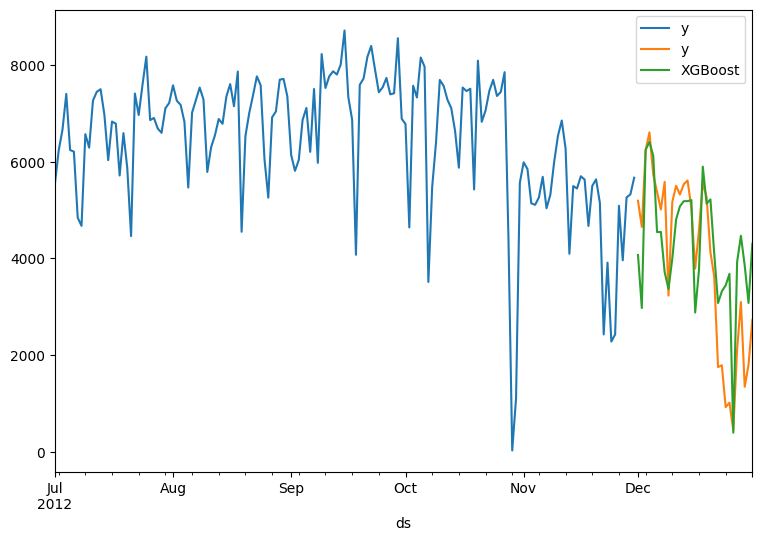

In [144]:
#Viz
training_set.y['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions_xgb.plot(legend = True)

In [146]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_xgb),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_xgb)), 0))

973.0
1233.0


In [147]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_xgb)

46.236435785499836